In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [2]:
period_order = [35, 36, 40, 39, 42, 43, 41, 46, 47, 44, 49, 50, 48, 53, 54, 51, 52, 56, 55, 58, 59, 57, 61]
period_order_name = ["2017-2018A", "2017-2018B", "2017-2018V", "2018-2019A", "2018-2019B", "2018-2019V",
                     "2019-2020A", "2019-2020B", "2019-2020V", "2020-2021A", "2020-2021B", "2020-2021V",
                     "2021-2022A", "2021-2022B", "2021-2022V", "2022-2023A", "2022-2023B", "2022-2023V",
                     "2023-2024A", "2023-2024B", "2023-2024V", "2024-2025A", "2024-2025B"]

# Mapear id_periodo a su nombre y tipo (A, B, V)
period_map = {id_p: name for id_p, name in zip(period_order, period_order_name)}
period_type = {id_p: name[-1] for id_p, name in zip(period_order, period_order_name)}

In [3]:
def load_period_csvs_into_vars(base_directory):
    """
    Carga los archivos CSV de calificaciones organizados por periodo y carrera
    en variables globales con el formato p<periodo>.
    Cada variable p<periodo> será un diccionario, donde las claves son los nombres
    de los archivos CSV (con el formato p<periodo>c<carrera>s<semestre>) y los
    valores son DataFrames de pandas.

    Args:
        base_directory (str): La ruta base donde se encuentran las carpetas de 'Periodo_XX'.

    Returns:
        dict: Un diccionario donde cada clave es 'p<periodo>' y su valor es otro
              diccionario que contiene los DataFrames de los CSVs de ese período.
              Retorna un diccionario vacío si no se encuentran archivos.
    """
    period_data = {}

    if not os.path.exists(base_directory):
        print(f"Error: El directorio base '{base_directory}' no existe.")
        return period_data

    # Iterate over Periodo folders
    for period_folder_name in os.listdir(base_directory):
        if period_folder_name.startswith("Periodo_"):
            period_id = period_folder_name.replace("Periodo_", "")
            period_path = os.path.join(base_directory, period_folder_name)

            if os.path.isdir(period_path):
                current_period_dfs = {}

                # Iterate over Carrera folders within the period folder
                for career_folder_name in os.listdir(period_path):
                    if career_folder_name.startswith("Carrera_"):
                        career_path = os.path.join(period_path, career_folder_name)

                        if os.path.isdir(career_path):
                            for file_name in os.listdir(career_path):
                                if file_name.endswith(".csv"):
                                    csv_path = os.path.join(career_path, file_name)
                                    parts = os.path.splitext(file_name)[0].split('periodo')[1].split('carrera')
                                    period_part = parts[0]
                                    career_sem_parts = parts[1].split('semestre')
                                    career_part = career_sem_parts[0]
                                    semestre_part = career_sem_parts[1]

                                    df_name = f"p{period_part}c{career_part}s{semestre_part}"

                                    try:
                                        df = pd.read_csv(csv_path)
                                        current_period_dfs[df_name] = df
                                        print(f"Cargado: {file_name} en p{period_id}['{df_name}']")
                                    except Exception as e:
                                        print(f"Error al cargar {file_name}: {e}")

                period_var_name = f"p{period_id}"
                period_data[period_var_name] = current_period_dfs
    
    if not period_data:
        print(f"No se encontraron datos de períodos en '{base_directory}'.")
        
    return period_data

In [4]:
csv_base_folder = r"D:/TesisDB/CSV's"

# --- Cargar todos los CSVs ---
print(f"Cargando datos desde: {csv_base_folder}")
all_period_data = load_period_csvs_into_vars(csv_base_folder)

Cargando datos desde: D:/TesisDB/CSV's
Cargado: periodo35carrera10semestre1.csv en p35['p35c10s1']
Cargado: periodo35carrera10semestre3.csv en p35['p35c10s3']
Cargado: periodo35carrera10semestre5.csv en p35['p35c10s5']
Cargado: periodo35carrera10semestre7.csv en p35['p35c10s7']
Cargado: periodo35carrera10semestre9.csv en p35['p35c10s9']
Cargado: periodo35carrera11semestre1.csv en p35['p35c11s1']
Cargado: periodo35carrera11semestre3.csv en p35['p35c11s3']
Cargado: periodo35carrera2semestre1.csv en p35['p35c2s1']
Cargado: periodo35carrera2semestre3.csv en p35['p35c2s3']
Cargado: periodo35carrera2semestre5.csv en p35['p35c2s5']
Cargado: periodo35carrera2semestre7.csv en p35['p35c2s7']
Cargado: periodo35carrera2semestre9.csv en p35['p35c2s9']
Cargado: periodo35carrera3semestre1.csv en p35['p35c3s1']
Cargado: periodo35carrera3semestre3.csv en p35['p35c3s3']
Cargado: periodo35carrera3semestre5.csv en p35['p35c3s5']
Cargado: periodo35carrera3semestre7.csv en p35['p35c3s7']
Cargado: periodo35c

In [5]:
def analyze_population(data, p_map, p_type, c_names, target_sem, period_filter_type=None):
    """
    Función general para analizar la población en un semestre específico y tipo de período.
    Retorna un DataFrame con los resultados.
    """
    results = []
    
    # Filtrar periodos por tipo si se especifica, y ordenarlos
    filtered_periods = []
    if period_filter_type:
        filtered_periods = [p_id for p_id in period_order if p_type.get(p_id) == period_filter_type]
    else:
        filtered_periods = period_order # Todos los periodos si no hay filtro

    for p_id in filtered_periods:
        period_key = f"p{p_id}"
        period_name = p_map.get(p_id, f"Periodo {p_id}")

        if period_key in data:
            period_dfs = data[period_key]
            
            # Recopilar todos los DataFrames para el semestre objetivo en este período
            sem_dfs = {df_name: df for df_name, df in period_dfs.items() if df_name.endswith(f's{target_sem}')}

            if sem_dfs:
                for df_name, df in sem_dfs.items():
                    try:
                        carrera_id = int(df_name.split('c')[1].split('s')[0])
                        carrera_name = c_names.get(carrera_id, f"Carrera {carrera_id}")
                        num_students = df['matricula_hash'].nunique()
                        results.append({
                            'Periodo_ID': p_id,
                            'Periodo_Nombre': period_name,
                            'Carrera_ID': carrera_id,
                            'Carrera_Nombre': carrera_name,
                            'Semestre': target_sem,
                            'Num_Estudiantes': num_students
                        })
                    except (IndexError, ValueError):
                        pass # Ignore malformed df_names
    
    if not results:
        return pd.DataFrame(columns=['Periodo_ID', 'Periodo_Nombre', 'Carrera_ID', 'Carrera_Nombre', 'Semestre', 'Num_Estudiantes'])
    
    return pd.DataFrame(results)

In [6]:
def get_full_exploratory_df(data, p_map, p_type, c_names):
    """
    Genera el DataFrame completo para el análisis exploratorio.
    """
    all_students_data = []

    for p_id in period_order:
        period_key = f"p{p_id}"
        period_name = p_map.get(p_id, f"Periodo {p_id}")
        current_period_type = p_type.get(p_id, 'N/A')

        if period_key in data:
            period_dfs = data[period_key]
            for df_name, df in period_dfs.items():
                try:
                    carrera_id = int(df_name.split('c')[1].split('s')[0])
                    semestre_id = int(df_name.split('s')[1])
                    carrera_name = c_names.get(carrera_id, f"Carrera {carrera_id}")
                    num_students = df['matricula_hash'].nunique()

                    all_students_data.append({
                        'Periodo_ID': p_id,
                        'Periodo_Nombre': period_name,
                        'Tipo_Periodo': current_period_type,
                        'Carrera_ID': carrera_id,
                        'Carrera_Nombre': carrera_name,
                        'Semestre': semestre_id,
                        'Num_Estudiantes': num_students
                    })
                except (IndexError, ValueError):
                    pass
    
    return pd.DataFrame(all_students_data) if all_students_data else None

In [7]:
career_names = {}
for p_key, p_val in all_period_data.items():
    for df_key in p_val.keys():
        try:
            carrera_id = int(df_key.split('c')[1].split('s')[0])
            if carrera_id not in career_names:
                career_names[carrera_id] = f"Carrera {carrera_id}"
        except (IndexError, ValueError):
            pass

print(f"\nCarreras detectadas: {career_names}")


Carreras detectadas: {10: 'Carrera 10', 11: 'Carrera 11', 2: 'Carrera 2', 3: 'Carrera 3', 4: 'Carrera 4', 5: 'Carrera 5', 6: 'Carrera 6', 7: 'Carrera 7', 8: 'Carrera 8', 9: 'Carrera 9', 12: 'Carrera 12', 13: 'Carrera 13'}


In [8]:
df_first_sem = analyze_population(all_period_data, period_map, period_type, career_names, target_sem=1, period_filter_type='A')
df_tenth_sem = analyze_population(all_period_data, period_map, period_type, career_names, target_sem=10, period_filter_type='B')
df_full_exploratory = get_full_exploratory_df(all_period_data, period_map, period_type, career_names)

In [ ]:
def plot_sem_population(df, title, semester_num):
    if df.empty:
        print(f"No hay datos para graficar la población en {title}.")
        return

    plt.figure(figsize=(14, 7))
    
    # Crear un pivote para graficar por carrera y período
    pivot_df = df.pivot_table(index='Periodo_Nombre', columns='Carrera_Nombre', values='Num_Estudiantes', fill_value=0)
    
    # Ordenar los períodos en el eje X según period_order
    pivot_df = pivot_df.reindex([period_map[p_id] for p_id in period_order if period_map[p_id] in pivot_df.index])

    pivot_df.plot(kind='bar', ax=plt.gca(), width=0.8)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Período", fontsize=12)
    plt.ylabel("Número de Estudiantes", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Carrera", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_semestre_distribution(df, title="Distribución de Estudiantes por Semestre"):
    if df is None or df.empty:
        print(f"No hay datos para graficar la distribución de semestres en {title}.")
        return

    semestre_counts = df.groupby('Semestre')['Num_Estudiantes'].sum() # Suma total de estudiantes por semestre
    
    plt.figure(figsize=(12, 6))
    semestre_counts.plot(kind='bar', color='skyblue')
    
    plt.title(title, fontsize=16)
    plt.xlabel("Semestre", fontsize=12)
    plt.ylabel("Número Total de Estudiantes (acumulado)", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_enrollment_vs_graduation_proportion(df_first_sem, df_tenth_sem, p_map):
    if df_first_sem.empty and df_tenth_sem.empty:
        print("No hay suficientes datos para graficar la proporción de inscritos vs décimo semestre.")
        return

    # Sumar todas las carreras para el primer semestre
    enrollment_by_period = df_first_sem.groupby('Periodo_ID')['Num_Estudiantes'].sum().rename('First_Sem_Enrollment')
    
    # Sumar todas las carreras para el decimo semestre
    tenth_sem_by_period = df_tenth_sem.groupby('Periodo_ID')['Num_Estudiantes'].sum().rename('Tenth_Sem_Population')

    # Combinar los DataFrames por Periodo_ID
    combined_df = pd.merge(
        enrollment_by_period,
        tenth_sem_by_period,
        on='Periodo_ID',
        how='outer' # Usar outer para incluir todos los períodos si alguno falta en un lado
    ).fillna(0) # Rellenar con 0 donde no haya datos (Un periodo B sin decimo semestre)

    # Ordenar por el orden de los periodos definidos
    combined_df = combined_df.reindex(period_order).fillna(0)

    # Crear una lista de proporciones
    proportions_data = []
    
    # Filtrar solo periodos A (primer semestre) y B (décimo semestre)
    a_periods_sorted = sorted([p_id for p_id, p_type_val in period_type.items() if p_type_val == 'A'], key=lambda x: period_order.index(x))
    b_periods_sorted = sorted([p_id for p_id, p_type_val in period_type.items() if p_type_val == 'B'], key=lambda x: period_order.index(x))
    
    # Crear un DataFrame de estudiantes por periodo y semestre
    all_pop_df = df_full_exploratory
    if all_pop_df is None or all_pop_df.empty:
        print("No hay datos de población completos para la proporción.")
        return

    # Calcular la suma de estudiantes de 1er semestre por periodo A
    first_sem_pop = all_pop_df[(all_pop_df['Semestre'] == 1) & (all_pop_df['Tipo_Periodo'] == 'A')].groupby('Periodo_ID')['Num_Estudiantes'].sum()
    # Calcular la suma de estudiantes de 10mo semestre por periodo B
    tenth_sem_pop = all_pop_df[(all_pop_df['Semestre'] == 10) & (all_pop_df['Tipo_Periodo'] == 'B')].groupby('Periodo_ID')['Num_Estudiantes'].sum()
    
    cohort_data = []

    for i, p_id_a in enumerate(period_order):
        if period_type.get(p_id_a) == 'A' and p_id_a in first_sem_pop.index:
            enrollment = first_sem_pop.loc[p_id_a]
            
            p_id_a_index = period_order.index(p_id_a)
            
            target_b_idx = p_id_a_index + 13 # Aproximación de 4.5 años (1er sem A a 10mo sem B)
            
            target_p_id_b = None
            if target_b_idx < len(period_order):
                potential_p_id_b = period_order[target_b_idx]
                if period_type.get(potential_p_id_b) == 'B':
                    target_p_id_b = potential_p_id_b

            tenth_sem_pop_for_cohort = 0
            if target_p_id_b is not None and target_p_id_b in tenth_sem_pop.index:
                tenth_sem_pop_for_cohort = tenth_sem_pop.loc[target_p_id_b]
            
            # Calcular la proporción
            proportion = (tenth_sem_pop_for_cohort / enrollment) * 100 if enrollment > 0 else 0

            cohort_data.append({
                'Periodo_Inscripcion_ID': p_id_a,
                'Periodo_Inscripcion_Nombre': p_map.get(p_id_a, f"Periodo {p_id_a}"),
                'Estudiantes_1er_Sem': enrollment,
                'Periodo_10mo_Sem_ID': target_p_id_b,
                'Periodo_10mo_Sem_Nombre': p_map.get(target_p_id_b, f"Periodo {target_p_id_b}") if target_p_id_b else 'N/A',
                'Estudiantes_10mo_Sem': tenth_sem_pop_for_cohort,
                'Proporcion_Retencion': proportion
            })
    
    if not cohort_data:
        print("No se encontraron cohortes de 1er semestre vs 10mo semestre para graficar.")
        return

    cohort_df = pd.DataFrame(cohort_data)
    
    plt.figure(figsize=(14, 7))
    
    # Graficar las barras de Estudiantes_1er_Sem y Estudiantes_10mo_Sem
    bar_width = 0.35
    index = np.arange(len(cohort_df))
    
    plt.bar(index - bar_width/2, cohort_df['Estudiantes_1er_Sem'], bar_width, label='Estudiantes 1er Semestre (Periodo A)', color='skyblue')
    plt.bar(index + bar_width/2, cohort_df['Estudiantes_10mo_Sem'], bar_width, label='Estudiantes 10mo Semestre (Periodo B estimado)', color='lightcoral')
    
    # Crear un segundo eje Y para la proporción
    ax2 = plt.gca().twinx()
    ax2.plot(index, cohort_df['Proporcion_Retencion'], color='green', marker='o', linestyle='-', linewidth=2, label='Proporción (10mo/1ro Semestre) %')
    
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter()) # Formato de porcentaje
    ax2.set_ylabel("Proporción (%)", color='green', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title("Población en 1er Semestre (Periodo A) vs. 10mo Semestre (Periodo B Estimado) y Proporción", fontsize=16)
    plt.xlabel("Período de Inscripción (1er Semestre)", fontsize=12)
    plt.ylabel("Número de Estudiantes", fontsize=12)
    plt.xticks(index, cohort_df['Periodo_Inscripcion_Nombre'], rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Unir leyendas de ambos ejes
    lines, labels = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


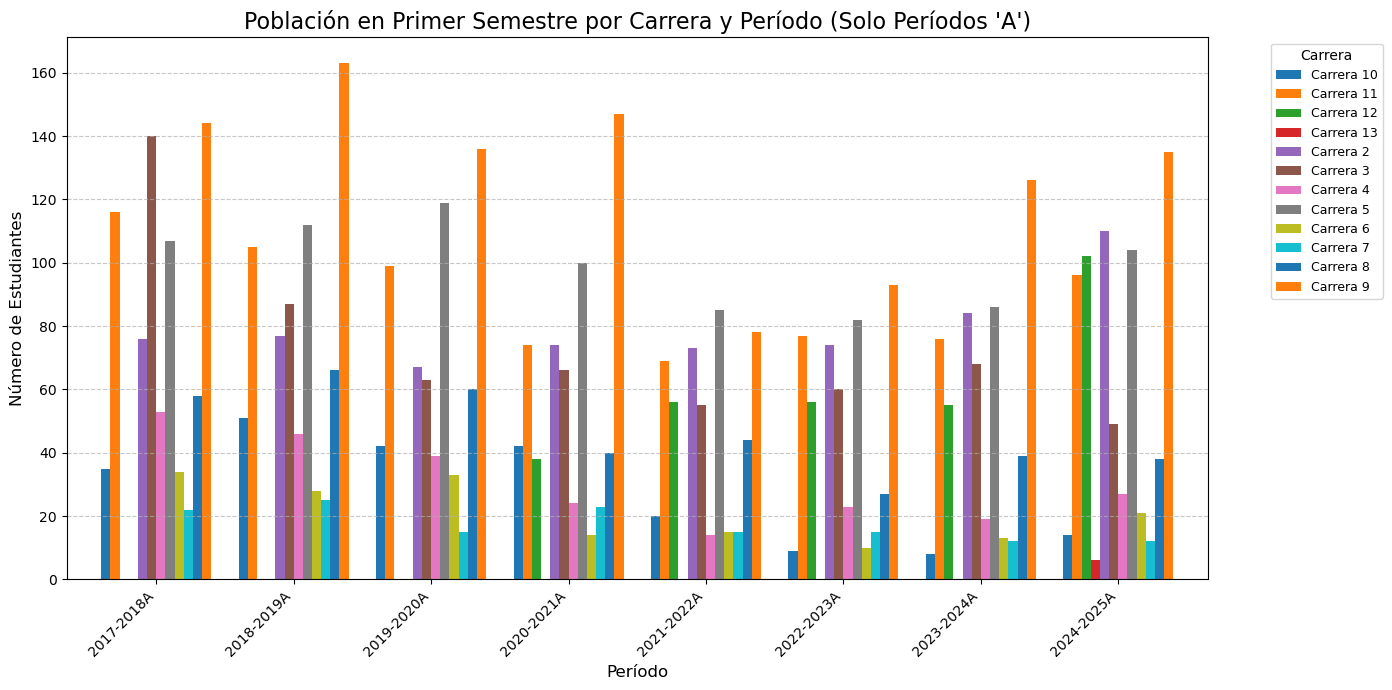

In [13]:
plot_sem_population(
    df_first_sem,
    "Población en Primer Semestre por Carrera y Período (Solo Períodos 'A')",
    semester_num=1
)

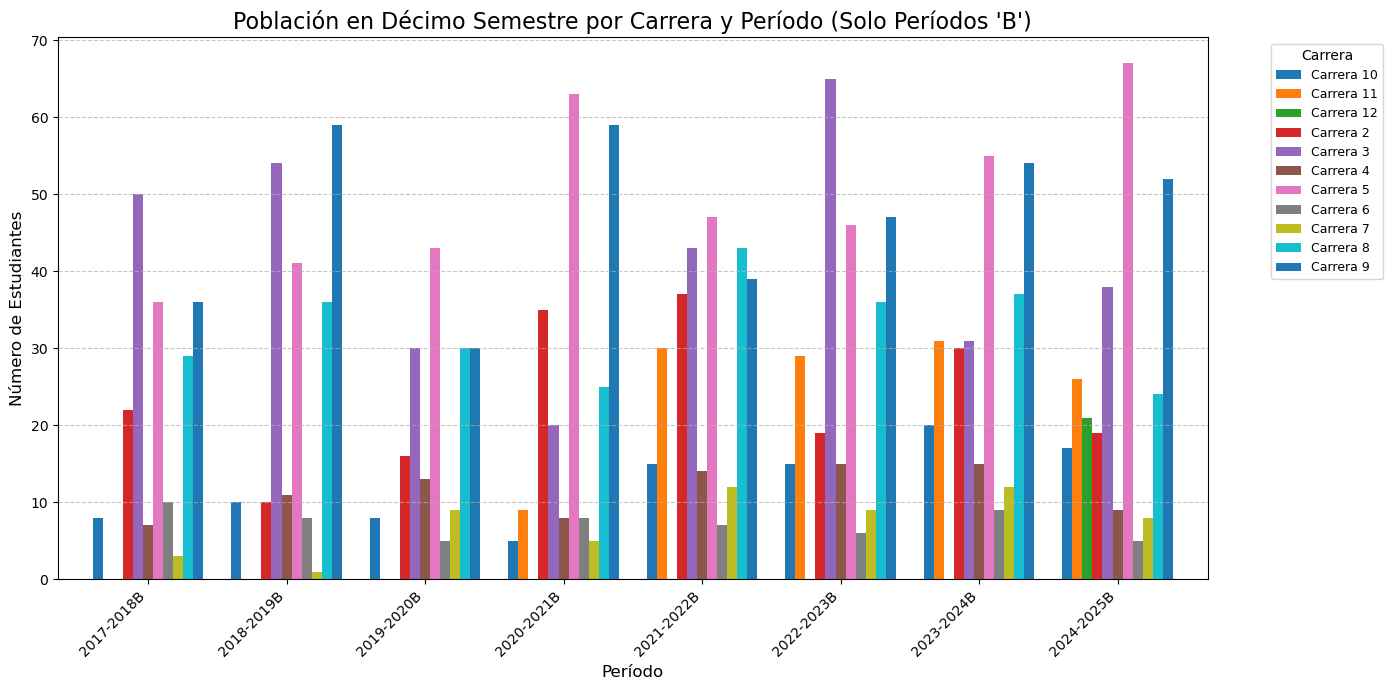

In [14]:
# Gráfica de Décimo Semestre
plot_sem_population(
    df_tenth_sem,
    "Población en Décimo Semestre por Carrera y Período (Solo Períodos 'B')",
    semester_num=10
)

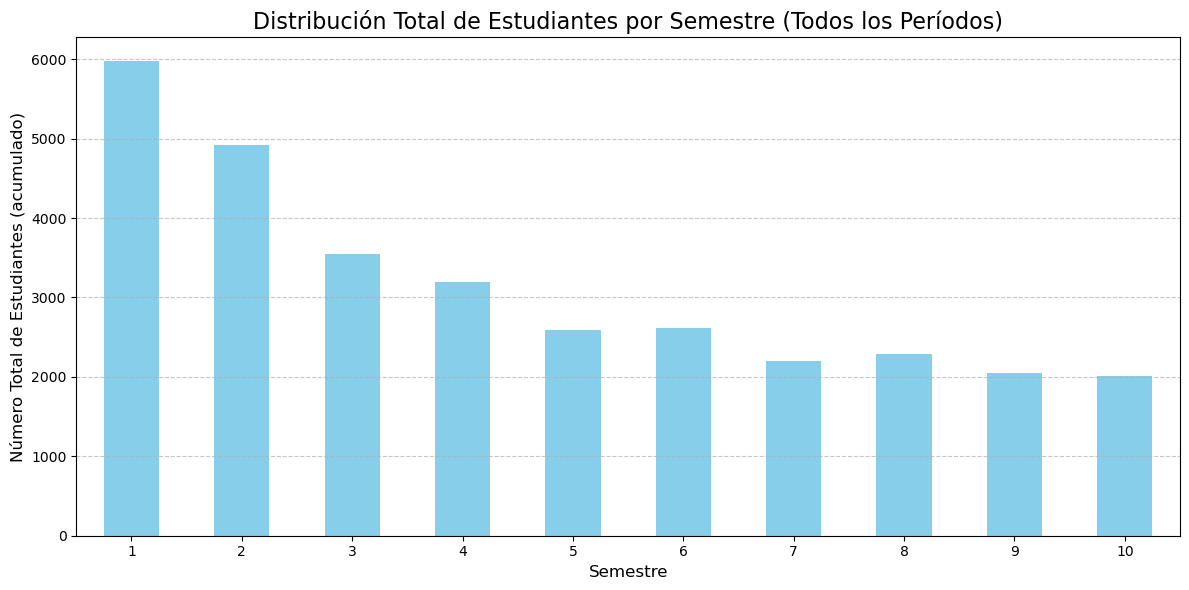

In [15]:
# Gráfica de Distribución General por Semestre
plot_semestre_distribution(
    df_full_exploratory,
    title="Distribución Total de Estudiantes por Semestre (Todos los Períodos)"
)

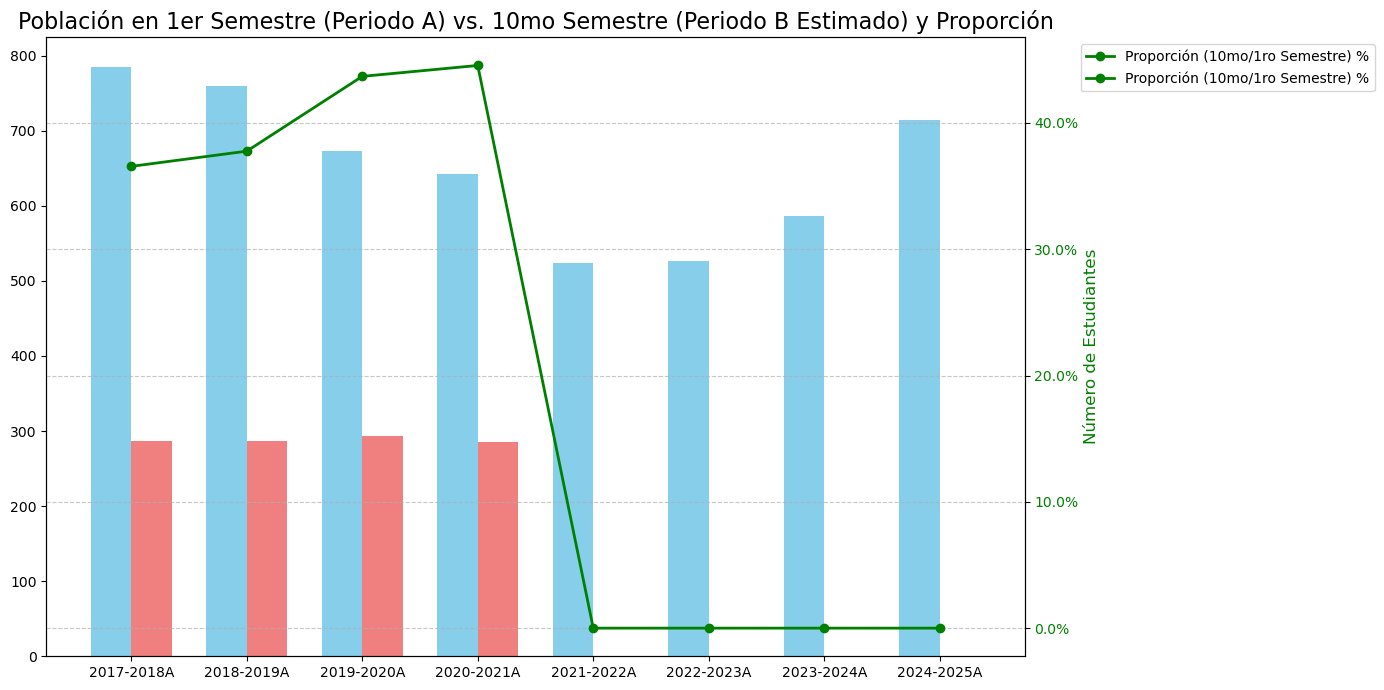

In [16]:
# Gráfica de Proporción de Inscritos vs. Décimo Semestre
plot_enrollment_vs_graduation_proportion(df_first_sem, df_tenth_sem, period_map)